# Fine-Tuning Image Captioning Model using PyTorch XPU backend

## Overview
This notebook demostrates how the VL model- [BLIP*large*](https://huggingface.co/Salesforce/blip-image-captioning-large) is fine-tuned to perform image captioning.

## Workflow 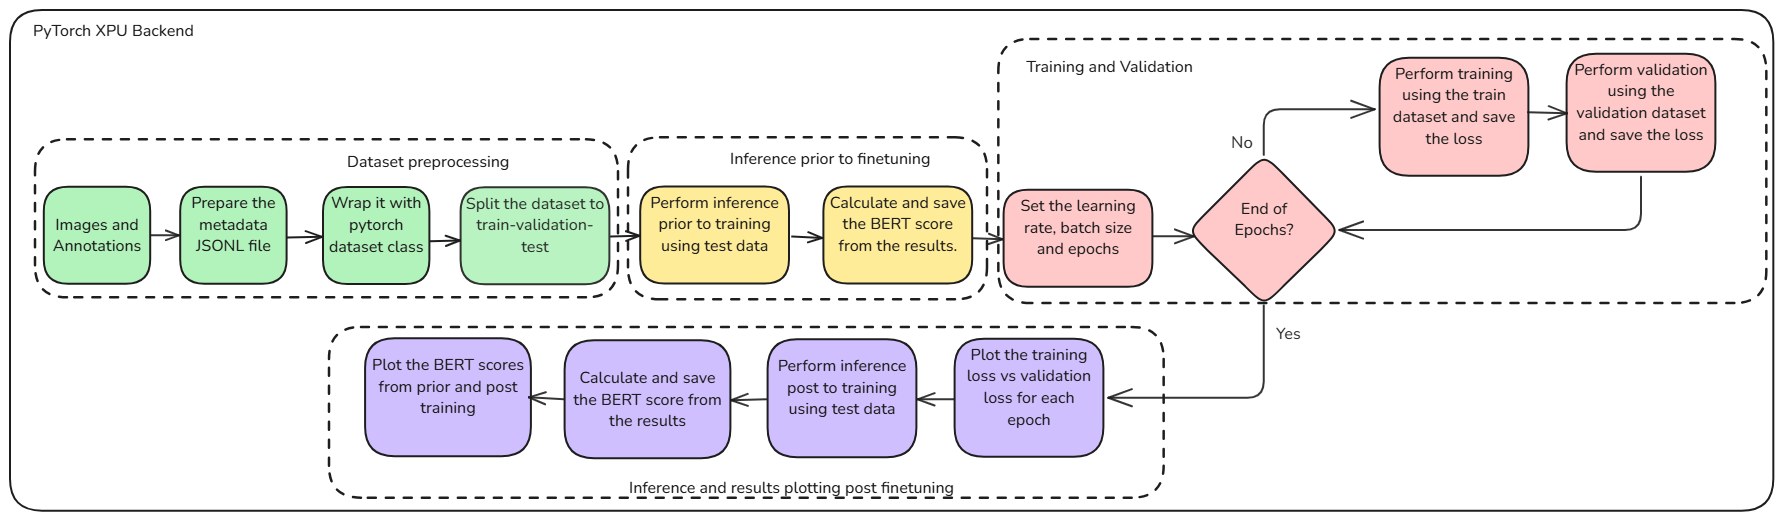

## Import necessary packages

In [ ]:
import os
from pathlib import Path
import json
from datasets import load_dataset 
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from transformers import BlipProcessor, BlipForConditionalGeneration
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
import time
from evaluate import load
import zipfile

## Prepare the metadata.jsonl file in the images directory. 
The image dataset is prepared using the huggingface ImageFolder - a dataset builder. More info at : https://huggingface.co/docs/datasets/image_dataset#imagefolder

In [11]:
def prepare_metadatajsonl(annotations_root_folder,images_root_folder):
    """
    Processes JSON annotation files to generate a metadata JSONL file for the image dataset.
    The JSONL file in the given format is required to load the dataset using huggingface image loader.
    Args:
        annotations_root_folder (Path): The root folder containing JSON annotation files.
        images_root_folder (str): The directory where images are stored and metadata is saved.
    Returns:
        bool: True if metadata.jsonl file is successfully created, False otherwise.
    Functionality:
    - Reads JSON files from `annotations_root_folder`.
    - Extracts `uniqueID` and `caption` from each JSON file.
    - Constructs a metadata dictionary mapping image file names to captions.
    - Saves metadata as `metadata.jsonl` in `images_root_folder`.
    - Confirms the file was successfully created.
    """
    try:
        dataset_list = []
        for json_file in list(annotations_root_folder.glob("*.json")): # Loop through all JSON files in the folder
            with json_file.open('r') as file: # Open and load each JSON file
                indv_dict={}
                data = json.load(file)
                unique_id = data.get("uniqueID")  
                unique_id_png = f"{unique_id}.png"
                caption = data.get("caption")
                indv_dict['file_name']=unique_id_png
                indv_dict['text']=caption
                indv_dict['image_path'] = str(images_root_folder / unique_id_png)
                dataset_list.append(indv_dict)
        metadata_file = images_root_folder / "metadata.jsonl"
        with open(str(metadata_file), 'w') as f: # add metadata.jsonl file to this folder
            for item in dataset_list:
                f.write(json.dumps(item) + "\n")
        if os.path.isfile(metadata_file): # check if metadata.jsonl file is created or not
            return True
        else:
            return False
    except Exception as e:
        print("Failed to create the metadata.jsonl file.\n")
        raise e

## The pytorch Dataset class is used to wrap the huggingface ImageFolder.
This lets us to use the pytorch dataloader. The image path is added to the encoding which enables to track the image file name later during inference.

In [12]:
class ImageCaptioningDataset(Dataset):
    """
    A PyTorch dataset class that wraps around the huggingface image folder.
    This makes it easier to load the data using the pytorch dataloader.
    Args:
        dataset (Dataset): A dataset containing image-text pairs.
        processor (Processor): A processor that handles image and text encoding.
    Methods:
        __len__(): Returns the number of items in the dataset.
        __getitem__(idx): Retrieves the item at the specified index, processes the image and text, 
                          and returns the encoding.
    Returns:
        dict: A dictionary containing the processed image, text, attention mask, and image path.
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt",
                                  return_attention_mask=True
                                  )
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        encoding['image_path'] = item['image_path']
        return encoding

## The dataset is then split to train-validation-test in the specifed ratio.
We have split the dataset to training,validation,test as 80%, 10% ,10% correspondingly. Out of 1374 images, this corresponds to 1099-137-138 images.

In [13]:
def datasplit(full_dataset,train_ratio,val_ratio,test_ratio,datasetsplit_seed):
    """
    Splits the given dataset into training, validation, and test sets based on specified ratios.
    Args:
        full_dataset (Dataset): The complete dataset to be split.
        train_ratio (float): Proportion of the dataset to use for training (e.g., 0.8 for 80%).
        val_ratio (float): Proportion of the dataset to use for validation (e.g., 0.1 for 10%).
        test_ratio (float): Proportion of the dataset to use for testing (e.g., 0.1 for 10%).
        datasetsplit_seed (int): Seed for reproducibility of dataset splitting.
    Returns:
        tuple: A tuple containing the training, validation, and test datasets.
    """
    try:
        total_size = len(full_dataset)
        train_size = int(train_ratio * total_size)
        val_size = int(val_ratio * total_size)
        test_size = total_size - train_size - val_size
    
        generator = torch.Generator().manual_seed(datasetsplit_seed) #split wtih fixed seed
        train_set,val_set,test_set = random_split(full_dataset,[train_size,val_size,test_size],generator=generator)
        print(f"The dataset is split into {train_ratio*100}% train ,{val_ratio*100}% validation and {test_ratio*100}% test ")
        print(f"Of total size {total_size} train-validation-test set is correspondigly {len(train_set)}-{len(val_set)}-{len(test_set)}")
        return train_set,val_set,test_set
    except Exception as e:
        print("Failed to split the dataset.\n")
        raise e

## Fetch the actual caption for an image. 
It is to be used during inference and saved into the results.

In [14]:
def get_actualcaption(subset,index):
    """
    Retrieves the actual caption text from the full dataset.
    Args:
        subset (Subset): A subset of the dataset containing indices.
        index (int): The index within the subset to retrieve the corresponding original dataset entry.
    Returns:
        str: The caption text associated with the original dataset entry.
    """
    try:
        original_idx = subset.indices[index]
        return full_dataset.dataset[original_idx]["text"]
    except Exception as e:
        print("Failed to retrieve the actual caption from full dataset")
        raise e

## The BERT score between the predicted/generated caption and the reference/actual caption is calculated. 
It leverages the BERT embeddings model (bert-base-uncased) and uses cosine similarity to match between the actual and predicted captions. There is a list of embedding models that can be used. For more details refer - [BERTscore](https://huggingface.co/spaces/evaluate-metric/bertscore)

In [15]:
def calculate_bert(references,predictions):
    """
    Computes the BERTScore F1 metric for evaluating the similarity between predicted and reference texts.
    Args:
        references (list of str): A list of reference texts.
        predictions (list of str): A list of predicted texts.
    Returns:
        float: The F1 score from BERTScore, measuring the similarity between predictions and references.
    """
    try:
        bertscore = load("bertscore")
        results = bertscore.compute(predictions=predictions, references=references ,model_type="bert-base-uncased")
        return results['f1']
    except Exception as e:
        print("Failed to calculate the bertscore.\n")
        raise e

## Write the results out to a csv file. 
The csv file contains the generated caption, actual caption and their BERT score for each image. The results are written out twice- prior and post finetuning.

In [16]:
def write_results_to_csv(csv_list,csv_file):
    """
    Write a list of data(the generated caption,actual caption,BERTscore) to a CSV file.
    The results will be written twice- prior and subsequent to finetuning.
    Args:
        csv_list (list): A list of dictionaries or lists representing rows of data.
        csv_file (str): The file path where the CSV should be saved.
    Returns:
        None
    """
    try:
        df = pd.DataFrame(csv_list)
        df.to_csv(csv_file,index=False)
    except Exception as e:
        print("Failed to write the results to csv file.\n")
        raise e

## Perform inferencing with the model. 
The inferencing is conducted both before and after fine-tuning to assess its effectiveness.

In [17]:
def inference_with_model(data_set,finetune_complete=False):
    """
    Performs inference using the trained model on the given dataset of images and captions.
    The function processes each image from the dataset, generates captions using a trained model, 
    and computes the BERT F1 score by comparing the generated caption with the actual caption. 
    It collects results, prints summary statistics (inference time and average score), 
    and saves the results to a CSV file, distinguishing between pre- and post-finetuning scenarios.
    Args:
        data_set (test data split): A list of dictionaries, each containing an image path and corresponding metadata.
        finetune_complete (bool, optional): Indicates whether the model has been fine-tuned. Defaults to False.
    Returns:
        list: A list of individual BERT F1 scores for each image-caption pair.
    """
    try:
        model.eval()
        before_time = time.time()
        print("Inferencing in progress.......")
        f1_total=0
        f1_indv_list=[]
        results_list=[]
        for key,value in enumerate(tqdm(data_set)):
            results_dict={}
            pngfilename=value['image_path']
            actualcaption=get_actualcaption(data_set,key)
            image = Image.open(pngfilename)
            inputs = processor(images=image, return_tensors="pt").to(device)
            pixel_values = inputs.pixel_values
            generated_ids = model.generate(pixel_values=pixel_values, max_length=150)
            generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0] 
            f1 = calculate_bert([actualcaption],[generated_caption]) 
            f1_total += f1[0]
            f1_indv_list.append(f1[0])
            results_dict['filename'] = pngfilename
            results_dict['actual_caption'] = actualcaption
            results_dict['generated_caption'] = generated_caption
            results_dict['BERT_f1_score'] = f1[0]
            results_list.append(results_dict)
        tot_inference_time = time.time()-before_time
        if finetune_complete:
            print(f"For dataset size {len(data_set)}, total inference time after finetuning is {tot_inference_time:.5f} seconds")
            print(f"Average inference time is {tot_inference_time/len(data_set):.5f} seconds/image")
            print(f"The average BERT score is {f1_total/len(data_set):.3f}")
            csv_file = f"hephaestus_{model_id_edited}_Epoch {num_epochs}_Batch {batch_size}_after.csv"
            write_results_to_csv(results_list,csv_file)
        else:
            print(f"For dataset size {len(data_set)}, total inference time before finetuning is {tot_inference_time:.5f} seconds")
            print(f"Average inference time is {tot_inference_time/len(data_set):.5f} seconds/image")
            print(f"The average BERT score is {f1_total/len(data_set):.3f}")
            csv_file = f"hephaestus_{model_id_edited}_Epoch {num_epochs}_Batch {batch_size}_before.csv"
            write_results_to_csv(results_list,csv_file)
        return f1_indv_list
    except Exception as e:
        print("Inference using the model failed.\n")
        raise e

## Perform training using the model. The train loader and validation loader are used to load the data in the specified batch size.

In [18]:
def train_model(train_loader,val_loader):
    """
    Trains the model using the provided training and validation data loaders.
    The function performs the following steps:
    1. Iterates through the specified number of epochs.
    2. Trains the model using the training data, calculating and storing loss values.
    3. Evaluates the model on validation data and stores validation losses.
    4. Prints the training progress and loss values at each epoch.
    5. Saves the trained model's state to a file upon completion.
    Args:
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    Returns:
        tuple: A tuple containing two lists:
            - train_losses (list): List of average training losses per epoch.
            - val_losses (list): List of average validation losses per epoch.
    """
    try:
        print("Training started............")
        train_losses = []
        val_losses = []
        training_time=time.time()
        for epoch in range(1,num_epochs+1):
            print("Epoch:", epoch)
    
            model.train()
            train_loss = 0.0
            for idx, batch in enumerate(tqdm(train_loader)):
                optimizer.zero_grad()
                input_ids = batch.pop("input_ids").to(device)
                pixel_values = batch.pop("pixel_values").to(device)
                attention_mask = batch.pop("attention_mask").to(device)
                outputs = model(input_ids=input_ids,pixel_values=pixel_values,labels=input_ids,attention_mask=attention_mask)
                loss = outputs.loss
                train_loss +=  loss.item()
                loss.backward()
                optimizer.step()            
            train_losses.append(train_loss/len(train_loader))
    
            model.eval()
            val_loss=0.0
            with torch.no_grad():
                for idx,batch in enumerate(tqdm(val_loader)):
                    input_ids = batch.pop("input_ids").to(device)
                    pixel_values = batch.pop("pixel_values").to(device)
                    attention_mask = batch.pop("attention_mask").to(device)
                    outputs = model(input_ids=input_ids,pixel_values=pixel_values,labels=input_ids,attention_mask=attention_mask)  
                    loss = outputs.loss
                    val_loss += loss.item()
            val_losses.append(val_loss/len(val_loader))
            print(f"Epoch {epoch}/{num_epochs}" 
                  f"| Train loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
    
        print(f"Training completed. Time taken for training: {(time.time()-training_time):.5f} seconds")
        torch.save(model.state_dict(),f"{model_id_edited}_hephaestus.pth")#save model
        return train_losses,val_losses
    except Exception as e:
        print("Finetuning the model failed.\n")
        raise e

## Plotting the loss curve.
Plot the training loss and validation loss against each epoch. This helps to detect overfitting/underfitting and also helps to determine the optimization strategies.

In [19]:
def plot_loss_vs_epoch(train_losses,val_losses):
    """
    Plots training and validation loss against epochs and saves the figure.
    Args:
        train_losses (list): Loss values for training data across epochs.
        val_losses (list): Loss values for validation data across epochs.
    Returns:
        None: The function generates a plot and saves it as an image file.
    """
    try:
        fig, ax = plt.subplots()  # Create figure and axis first
        ax.plot(train_losses,label="Training loss",color="blue", marker='o')  # Use ax to plot
        ax.plot(val_losses,label="Validation loss",color="red", marker='x')
        ax.set_xlabel('Epoch',fontsize=12)
        ax.set_ylabel('Loss',fontsize=12)
        ax.set_title(f'Training Vs Validation loss - {model_id_edited}_Epoch: {num_epochs}_Batchsize: {batch_size} ',fontsize=10)
        ax.legend(fontsize=12)
        ax.grid(True,linestyle='--',alpha=0.7)
        ax.set_yscale('log') #compress the scale to show small changes clearly
        fig.savefig(f"training_val_loss_{model_id_edited}_Epoch {num_epochs}_Batch {batch_size}.png",dpi=300,bbox_inches='tight')# Save the figure
        plt.close(fig)  # Close the figure to free memory
    except Exception as e:
        print("Failed to plot the loss vs epoch.\n")
        raise e

## Plot the BERT score calculated between actual and generated caption for each image.

In [20]:
def plot_bert(indv_bert_before,indv_bert_after): 
    """
    Plots the BERT score of each image from the test data ,before and after training.
    Args:
        indv_bert_before (list): BERT scores before training.
        indv_bert_after (list): BERT scores after training.
    Returns:
        None: The plot is saved as an image file.
    """
    try:
        fig, ax = plt.subplots(figsize=(12, 6))  # Create figure and axis first
        ax.plot(indv_bert_before,label="BERT score before training",color="blue", marker='o')  # Use ax to plot
        ax.plot(indv_bert_after,label="BERT score after training",color="red", marker='x')
        ax.set_xlabel('Images',fontsize=12)
        ax.set_ylabel('BERT',fontsize=12)
        ax.set_title(f'Before Vs After Training-BERT score- {model_id_edited}-Epoch: {num_epochs}-Batchsize: {batch_size} ',fontsize=10)
        ax.legend(fontsize=12)
        ax.grid(True,linestyle='--',alpha=0.7)
        #ax.set_yscale('log') #compress the scale to show small changes clearly
        fig.savefig(f"Before Vs After Training_BERTscore_{model_id_edited}_Epoch {num_epochs}_Batch {batch_size}.png",dpi=300,bbox_inches='tight')# Save the figure
        plt.close(fig)  # Close the figure to free memory
    except Exception as e:
        print("Failed to plot the BERT score.\n")
        raise e

## Display the key parameters prior to training.

In [21]:
def printkeydetails():
    """
    This function displays essential information about the model, including the model ID, number of epochs run, batch size,
    optimizer used, learning rate (LR) value, and the device on which the model is running.
    Args:
        None.
    Returns:
        None
    """	
    try:
        print("-"*50)
        print("Model used : ",model_id)
        print("Epochs     : ",num_epochs )
        print("Batch size : ",batch_size)
        print("Optimizer  : ",optimizer_name)
        print("LR value   : ",lr)
        print("Device used: ",device)
        print("-"*50)
    except Exception as e:
        print("Failed to display the finetuning details.\n")
        raise e

## Unzip the dataset files.
The files - images.zip and annotations.zip are unzipped to the dataset folder in current working directory.

In [22]:
def unzip_file(zip_path, extract_to=None):
    """
    Extracts the contents of the ZIP file to a specified directory.
    Parameters:
        zip_path (str): The path to the .zip file to be extracted.
        extract_to (str, optional): The directory to extract the files into.
                                    If not specified, uses the current working directory.
    Raises:
        FileNotFoundError: If the specified zip file does not exist.
        zipfile.BadZipFile: If the file is not a valid ZIP archive.
    """
    if extract_to is None:
        extract_to = os.getcwd()
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            for member in zip_ref.infolist():
                if member.is_dir(): # Skip directories
                    continue
                filename = os.path.basename(member.filename)
                target_path = os.path.join(extract_to, filename)
                with zip_ref.open(member) as source, open(target_path, "wb") as target:
                    target.write(source.read())
            print(f"Successfully extracted '{zip_path}' to '{extract_to}'")
    except FileNotFoundError:
        print(f"Error: File '{zip_path}' not found.")
    except zipfile.BadZipFile:
        print(f"Error: '{zip_path}' is not a valid zip file.")

Set the paths to zip files and call the unzip method.

In [23]:
images_zip_filepath1 = Path("Hephaestus_dataset")/"images_set1.zip"
images_zip_filepath2 = Path("Hephaestus_dataset")/"images_set2.zip"
images_zip_filepath3 = Path("Hephaestus_dataset")/"images_set3.zip"
images_zip_filepath4 = Path("Hephaestus_dataset")/"images_set4.zip"
zip_files = [images_zip_filepath1,images_zip_filepath2,images_zip_filepath3,images_zip_filepath4]
annotations_zip_file_path = Path("Hephaestus_dataset")/ "annotations.zip"
images_destination_folder = Path("Hephaestus_dataset")/"images"
annotations_destination_folder = Path("Hephaestus_dataset")/"annotations"
os.makedirs(images_destination_folder, exist_ok=True)
os.makedirs(annotations_destination_folder, exist_ok=True)

for zip_file in zip_files:
    # Check if the file exists
    if zip_file.exists():
        print(f"Found {zip_file} file")
        unzip_file(zip_file, images_destination_folder)
    else:
        print(f"The {zip_file} file not found.")
    
if annotations_zip_file_path.exists():
    print("Found annotations.zip file")
    unzip_file(annotations_zip_file_path, annotations_destination_folder)
else:
    print("The annotations.zip file not found.")

Found Hephaestus_dataset\images_set1.zip file
Successfully extracted 'Hephaestus_dataset\images_set1.zip' to 'Hephaestus_dataset\images'
Found Hephaestus_dataset\images_set2.zip file
Successfully extracted 'Hephaestus_dataset\images_set2.zip' to 'Hephaestus_dataset\images'
Found Hephaestus_dataset\images_set3.zip file
Successfully extracted 'Hephaestus_dataset\images_set3.zip' to 'Hephaestus_dataset\images'
Found Hephaestus_dataset\images_set4.zip file
Successfully extracted 'Hephaestus_dataset\images_set4.zip' to 'Hephaestus_dataset\images'
Found annotations.zip file
Successfully extracted 'Hephaestus_dataset\annotations.zip' to 'Hephaestus_dataset\annotations'


## The main method that curates each process step by step.
<div class="alert alert-warning">
The following code cell will take around 10 minutes to complete. Please be patient!
</div>

In [24]:
import sys
if __name__ =="__main__":
    """
    Main script for preparing metadata, loading and fine-tuning the image captioning model, and evaluating its performance.
    This script:
    1. Sets up paths for image and annotation data.
    2. Prepares metadata for training.
    3. Loads the pretrained BLIP large image captioning model and processor.
    4. Loads dataset from the specified image folder.
    5. Splits the dataset into training, validation, and test sets.
    6. Moves the model to an appropriate computation device (CPU/XPU).
    7. Performs initial inference before fine-tuning.
    8. Configures optimizer and prepares data loaders.
    9. Fine-tunes the model using training and validation datasets.
    10. Plots training loss over epochs.
    11. Performs inference after fine-tuning for comparison.
    12. Visualizes performance improvements using BERT-based metrics.
    """
    images_root_folder = Path("Hephaestus_dataset")/"images"
    annotations_root_folder = Path("Hephaestus_dataset")/"annotations"

    metadatafile_prepared = prepare_metadatajsonl(annotations_root_folder,images_root_folder)
    if metadatafile_prepared:
        print("Succesfully created metadata jsonl file in the image folder.")
    else:
        raise FileNotFoundError(f"metadata jsonl file is not found in the image folder {images_root_folder}")
    
    model_id="Salesforce/blip-image-captioning-large"
    model_id_edited = model_id.replace("/","-")
    num_epochs= 4
    batch_size = 4
    train_ratio, val_ratio, test_ratio = 0.8,0.1,0.1
    datasetsplit_seed = 42

    try:
        processor = BlipProcessor.from_pretrained(model_id,local_files_only=True)
        model = BlipForConditionalGeneration.from_pretrained(model_id,local_files_only=True)
    except Exception as e:
        print(f"Model '{model_id}' is not available locally. Please download it first using the CLI command( refer README)")
        raise
    dataset = load_dataset("imagefolder", data_dir=images_root_folder, split="train")
    full_dataset = ImageCaptioningDataset(dataset, processor)
    train_set,val_set,test_set = datasplit(full_dataset,train_ratio,val_ratio,test_ratio,datasetsplit_seed)

    device = "xpu" if torch.xpu.is_available() else "cpu"
    model.to(device)
    indv_bert_before= inference_with_model(test_set,finetune_complete=False)

    lr = 5e-5
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    optimizer_name = optimizer.__class__.__name__
  
    train_loader = DataLoader(train_set,batch_size= batch_size,shuffle=True,)
    val_loader = DataLoader(val_set,batch_size=batch_size,shuffle= False,)

    printkeydetails()

Succesfully created metadata jsonl file in the image folder.


Resolving data files:   0%|          | 0/1375 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

The dataset is split into 80.0% train ,10.0% validation and 10.0% test 
Of total size 1374 train-validation-test set is correspondigly 1099-137-138
Inferencing in progress.......


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [04:41<00:00,  2.04s/it]

For dataset size 138, total inference time before finetuning is 281.50503 seconds
Average inference time is 2.03989 seconds/image
The average BERT score is 0.417
--------------------------------------------------
Model used :  Salesforce/blip-image-captioning-large
Epochs     :  4
Batch size :  4
Optimizer  :  AdamW
LR value   :  5e-05
Device used:  xpu
--------------------------------------------------


## Initiate training.
Once the training parameters are verified the below code snippet will initiate the training and then will perform the inference. Finally the results are also plotted.
<div class="alert alert-warning">
The following code cell will take around 1hour 20 minutes to complete. Please be patient!
</div>

In [25]:
    #
    train_losses,val_losses = train_model(train_loader,val_loader)
    #
    plot_loss_vs_epoch(train_losses,val_losses)
    #
    indv_bert_after = inference_with_model(test_set,finetune_complete=True)
    #
    plot_bert(indv_bert_before,indv_bert_after)

Training started............
Epoch: 1


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:55<00:00,  1.59s/it]


Epoch 1/4| Train loss: 1.2697 | Val Loss: 0.0669
Epoch: 2


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:54<00:00,  1.55s/it]


Epoch 2/4| Train loss: 0.0510 | Val Loss: 0.0435
Epoch: 3


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:55<00:00,  1.58s/it]


Epoch 3/4| Train loss: 0.0355 | Val Loss: 0.0367
Epoch: 4


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:54<00:00,  1.56s/it]


Epoch 4/4| Train loss: 0.0289 | Val Loss: 0.0333
Training completed. Time taken for training: 5464.09519 seconds
Inferencing in progress.......


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [07:14<00:00,  3.15s/it]


For dataset size 138, total inference time after finetuning is 434.11741 seconds
Average inference time is 3.14578 seconds/image
The average BERT score is 0.876
